In [1]:
from PIL import Image
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from einops import rearrange, einsum

In [2]:
from patched_clip.patched_clip import CLIP_args, get_clip_embeddings, load_clip, save_clip_embeddings

/Users/rogerq/anaconda3/envs/scene-nerf-viz/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/rogerq/anaconda3/envs/scene-nerf-viz/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /Users/rogerq/anaconda3/envs/scene-nerf-viz/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <44B645FB-F027-3EE5-86D7-DBF8E2FC6264> /Users/rogerq/anaconda3/envs/scene-nerf-viz/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from patched_clip import modified_clip

In [4]:
model, preprocess = load_clip()
device = CLIP_args.device

In [5]:
# text
class_list = ['chair', 'computer monitor', 'background', 'shelf', 'table', 'wall', 'floor', 'spoon']

text_inputs = torch.cat([modified_clip.tokenize(f"a photo of a {c}") for c in class_list]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=1, keepdim=True)

In [6]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x12a7f25f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [57]:
# image_paths = ['/Users/rogerq/Downloads/IMG_6694 Large.jpeg']
image_paths = ['test7.jpg']

In [58]:
# CLIP_args.clip_model_name = CLIPArgs.model_type
# CLIP_args.device = device
high_res_feature = True

# Load images into pillow images
images = [Image.open(image_path).resize((320, 240)) for image_path in image_paths]

# Get CLIP embeddings
with torch.no_grad():
    descriptors = get_clip_embeddings(images,
                                      to_cpu=False,
                                      model=model,
                                      preprocess=preprocess,
                                      skip_center_crop=high_res_feature)
    descriptors = descriptors.to(device)  # BCHW

timing <clip_preprocess_images>: 7.325E-03s


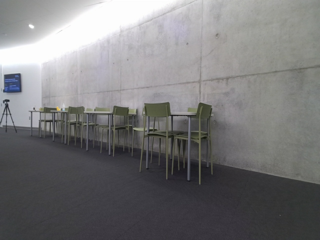

In [59]:
images[0]

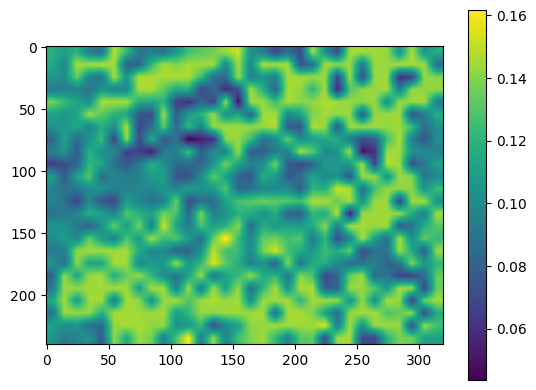

In [60]:
patch_features_bchw = descriptors / descriptors.norm(dim=1, keepdim=True)
similarity_mat_bhwc = einsum(patch_features_bchw, text_features, 'b c h w, d c -> b d h w')
similarity_mat_bhwc = F.interpolate(similarity_mat_bhwc, size=(240, 320), mode='bilinear', align_corners=False)
heatmap = similarity_mat_bhwc[0, 7, :, :].cpu().numpy()
plt.imshow(heatmap)
plt.colorbar()

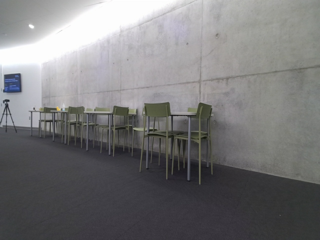

In [61]:
images[0].resize((320, 240))

In [62]:
from patched_clip.utils import visualize_embedding_pca

In [63]:
pca_images = visualize_embedding_pca(
                image_paths,
                images,
                descriptors,
                preprocess=preprocess,
                visualize_every=CLIP_args.visualize_every,
                patch_size=14,
                skip_center_crop=True
            )

Saved image at figures/test7_viz.png.


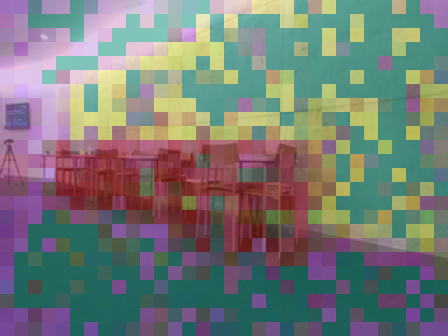

In [64]:
pca_images[0]